In [1]:
assignment_path = '/content/gdrive/My Drive/CIS680_2021/HW4/'
  
# Mount your drive
from google.colab import drive
drive.mount("/content/gdrive")

# Setup assignment folder and switch
import os
os.makedirs(assignment_path, exist_ok=True)
os.chdir(assignment_path)

import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import ndimage
from dataset import BuildDataset, BuildDataLoader
from functools import partial
import copy
import matplotlib.pyplot as plt


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from utils import *
from dataset import *

import matplotlib.pyplot as plt
# from rpn import *
from utils import MultiApply, IOU, output_flattening, output_decoding, convert_xywh, convert_xyxy
import matplotlib.patches as patches

In [3]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]

# imgs    = h5py.File(paths[0],'r')['data']
# masks   = h5py.File(paths[1],'r')['data']
# labels = np.load(paths[2], allow_pickle=True)
bounding_boxs   = np.load(paths[3], allow_pickle=True)

## Anchor Box Creation

In [4]:
ratios = []
scales = []
for bboxes in bounding_boxs:
    for x1, y1, x2, y2 in bboxes:
        w, h = (x2-x1), (y2-y1)
        aspect_ratio = w/h
        scale = np.sqrt(w*h)
        ratios.append(aspect_ratio)
        scales.append(scale)

(array([ 80., 512., 715., 624., 482., 465., 352., 210., 135.,  84.,  63.,
         34.,  22.,  17.,  10.,  11.,   8.,   6.,   2.,   3.,   3.,   1.,
          1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.09615559, 0.32600603, 0.55585647, 0.78570694, 1.0155574 ,
        1.2454078 , 1.4752582 , 1.7051088 , 1.9349592 , 2.1648097 ,
        2.39466   , 2.6245105 , 2.854361  , 3.0842113 , 3.3140619 ,
        3.5439124 , 3.7737627 , 4.003613  , 4.233464  , 4.463314  ,
        4.6931643 , 4.923015  , 5.1528654 , 5.3827157 , 5.6125665 ,
        5.842417  , 6.072267  , 6.302118  , 6.531968  , 6.7618184 ,
        6.991669  , 7.2215195 , 7.45137   , 7.6812205 , 7.911071  ,
        8.140922  , 8.370771  , 8.600622  , 8.830473  , 9.060323  ,
        9.290174  ], dtype=float32),
 <a list of 40 Patch objects>)

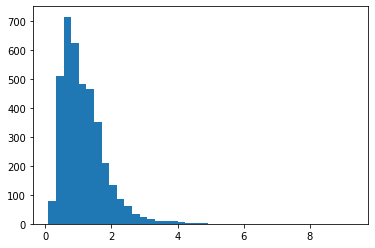

In [5]:
plt.hist(ratios, bins=40)

(array([106., 229., 244., 287., 322., 302., 288., 250., 274., 240., 226.,
        218., 191., 152., 132., 126., 100.,  70.,  59.,  27.]),
 array([ 32.79664 ,  48.43848 ,  64.08032 ,  79.72217 ,  95.364006,
        111.00585 , 126.64769 , 142.28954 , 157.93138 , 173.57321 ,
        189.21506 , 204.8569  , 220.49875 , 236.1406  , 251.78242 ,
        267.4243  , 283.0661  , 298.70795 , 314.3498  , 329.99164 ,
        345.63348 ], dtype=float32),
 <a list of 20 Patch objects>)

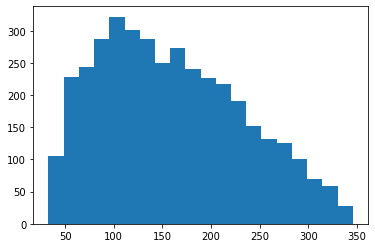

In [6]:
plt.hist(scales, bins=20)

In [7]:
aspect_ratio = 0.7
scale = 100

In [8]:
# for data in train_loader:
#     break

In [17]:
import torch
from torch.nn import functional as F
from torchvision import transforms
from torch import nn, Tensor
# from dataset import *
# from utils import *

import torchvision


class RPNHead(torch.nn.Module):

    def __init__(self,  device='cuda', anchors_param=dict(ratio=0.8,scale= 256, grid_size=(50, 68), stride=16)):
        # Initialize the backbone, intermediate layer clasifier and regressor heads of the RPN
        super(RPNHead,self).__init__()

        self.device=device
        # TODO Define Backbone
        channels = [16, 32, 64, 128, 256]
        inchannel = 3
        self.backbone = nn.ModuleList()
        for i, chn in enumerate(channels):
            self.backbone.append(nn.Conv2d(inchannel, chn, 5, padding="same"))
            self.backbone.append(nn.BatchNorm2d(chn))
            self.backbone.append(nn.ReLU())
            if i < len(channels) - 1:
                self.backbone.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
            inchannel = chn


        # TODO  Define Intermediate Layer
        self.intermediate = nn.ModuleList()
        self.intermediate.append(nn.Conv2d(channels[-1], 256, 3, padding="same"))
        self.intermediate.append(nn.BatchNorm2d(256))
        self.intermediate.append(nn.ReLU())

        # TODO  Define Proposal Classifier Head
        self.classifier = nn.ModuleList()
        self.classifier.append(nn.Conv2d(256, 1, 1, padding="same"))
        self.classifier.append(nn.Sigmoid())

        # TODO Define Proposal Regressor Head
        self.regressor = nn.ModuleList()
        self.regressor.append(nn.Conv2d(256, 4, 1, padding="same"))

        #  find anchors
        self.anchors_param=anchors_param
        self.anchors=self.create_anchors(self.anchors_param['ratio'],self.anchors_param['scale'],self.anchors_param['grid_size'],self.anchors_param['stride'])
        self.ground_dict={}



    # Forward  the input through the backbone the intermediate layer and the RPN heads
    # Input:
    #       X: (bz,3,image_size[0],image_size[1])}
    # Ouput:
    #       logits: (bz,1,grid_size[0],grid_size[1])}
    #       bbox_regs: (bz,4, grid_size[0],grid_size[1])}
    def forward(self, X):

        #TODO forward through the Backbone
        X = self.forward_backbone(X)

        #TODO forward through the Intermediate layer
        for i, layer in enumerate(self.intermediate):
            X = layer(X)

        #TODO forward through the Classifier Head
        logits = X
        for i, layer in enumerate(self.classifier):
            logits = layer(logits)

        #TODO forward through the Regressor Head
        bbox_regs = X
        for i, layer in enumerate(self.regressor):
            bbox_regs = layer(bbox_regs)
        
        assert logits.shape[1:4]==(1,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
        assert bbox_regs.shape[1:4]==(4,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

        return logits, bbox_regs




    # Forward input batch through the backbone
    # Input:
    #       X: (bz,3,image_size[0],image_size[1])}
    # Ouput:
    #       X: (bz,256,grid_size[0],grid_size[1])
    def forward_backbone(self,X):
        #####################################
        # TODO forward through the backbone
        #####################################
        for i, layer in enumerate(self.backbone):
            X = layer(X)

        assert X.shape[1:4]==(256,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

        return X



    # This function creates the anchor boxes
    # Output:
    #       anchors: (grid_size[0],grid_size[1],4)
    def create_anchors(self, aspect_ratio, scale, grid_sizes, stride):
        anchors = torch.zeros((grid_sizes[0] , grid_sizes[1],4), device=self.device)
        img_h, img_w = grid_sizes[0] * stride, grid_sizes[1] * stride
        h = scale / aspect_ratio ** 0.5
        w = scale * aspect_ratio ** 0.5

        for i in range(grid_sizes[0]):
          for j in range(grid_sizes[1]):
            # x1 = max(stride*j+stride/2 - w/2, 0)
            # x2 = min(stride*j+stride/2 + w/2, img_w)
            # y1 = max(stride*i+stride/2 - h/2, 0)
            # y2 = min(stride*i+stride/2 + h/2, img_h)
            # anchors[i][j] = torch.Tensor([x1,y1,x2,y2])
            x = stride*j+stride/2
            y = stride*i+stride/2
            anchors[i][j] = torch.Tensor([x,y,w,h])

        ######################################
        # TODO create anchors
        ######################################
        assert anchors.shape == (grid_sizes[0] , grid_sizes[1],4)

        return anchors



    def get_anchors(self):
      
        return self.anchors



    # This function creates the ground truth for a batch of images by using
    # create_ground_truth internally
    # Input:
    #      bboxes_list: list:len(bz){(n_obj,4)}
    #      indexes:      list:len(bz)
    #      image_shape:  tuple:len(2)
    # Output:
    #      ground_clas: (bz,1,grid_size[0],grid_size[1])
    #      ground_coord: (bz,4,grid_size[0],grid_size[1])
    def create_batch_truth(self,bboxes_list,indexes,image_shape):
        bz = len(bboxes_list)
        ground_clas, ground_coord = MultiApply(self.create_ground_truth, bboxes_list, indexes, [self.anchors_param['grid_size']]*bz, [self.anchors]*bz, [image_shape]*bz)
        ground_clas = torch.stack(ground_clas, dim=0)
        ground_coord = torch.stack(ground_coord, dim=0)
        #####################################
        # TODO create ground truth for a batch of images
        #####################################
        assert ground_clas.shape[1:4]==(1,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
        assert ground_coord.shape[1:4]==(4,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

        return ground_clas, ground_coord


    # This function creates the ground truth for one image
    # It also caches the ground truth for the image using its index
    # Input:
    #       bboxes:      (n_boxes,4)
    #       index:       scalar (the index of the image in the total dataset used for caching)
    #       grid_size:   tuple:len(2)
    #       anchors:     (grid_size[0],grid_size[1],4)
    # Output:
    #       ground_clas:  (1,grid_size[0],grid_size[1])
    #       ground_coord: (4,grid_size[0],grid_size[1])
    def create_ground_truth(self, bboxes, index, grid_size, anchors, image_size):
        key = str(index)
        if key in self.ground_dict:
            groundt, ground_coord = self.ground_dict[key]
            return groundt, ground_coord

        new_bboxes = convert_xywh(bboxes).to(device=self.device)
        ious = []

        flatten_anchors = torch.flatten(anchors, end_dim=-2)
        flatten_anchors_xyxy = convert_xyxy(flatten_anchors)
        for bbox in bboxes:
            iou = IOU(flatten_anchors_xyxy, bbox)
            ious.append(iou)
        ious = torch.stack(ious, 1)
        ground_clas = torch.zeros(grid_size[0] * grid_size[1], device=self.device)
        ground_clas[(ious < 0.3).all(dim=1)] = -1
        ground_clas[ious.max(dim=0).indices] = 1
        ground_clas[(ious > 0.7).any(dim=1)] = 1
        ground_coord = torch.zeros((grid_size[0] * grid_size[1],4), device=self.device)
        assigned_boxes_indices = ious.max(dim=1).indices[ground_clas==1]
        # ground_coord[ground_clas==1] = new_bboxes[assigned_boxes_indices]
        assigned_anchors = flatten_anchors[ground_clas==1].to(device=self.device)
        assigned_boxes = new_bboxes[assigned_boxes_indices]
        assigned_boxes_relative = torch.zeros_like(assigned_boxes, device=self.device)
        assigned_boxes_relative[:, 0] = (assigned_boxes[:, 0] - assigned_anchors[:, 0]) / assigned_anchors[:, 2]
        assigned_boxes_relative[:, 1] = (assigned_boxes[:, 1] - assigned_anchors[:, 1]) / assigned_anchors[:, 3]
        assigned_boxes_relative[:, 2] = torch.log(assigned_boxes[:, 2]/assigned_anchors[:, 2])
        assigned_boxes_relative[:, 3] = torch.log(assigned_boxes[:, 3]/assigned_anchors[:, 3])

        ground_coord[ground_clas==1] = assigned_boxes_relative
        
        ground_clas = ground_clas.reshape((grid_size[0],grid_size[1],1)).permute((2,0,1))
        ground_coord = ground_coord.reshape((grid_size[0],grid_size[1], 4)).permute((2,0,1))
        #####################################################
        # TODO create ground truth for a single image
        #####################################################

        self.ground_dict[key] = (ground_clas, ground_coord)

        assert ground_clas.shape==(1,grid_size[0],grid_size[1])
        assert ground_coord.shape==(4,grid_size[0],grid_size[1])

        return ground_clas, ground_coord


    



    # Compute the loss of the classifier
    # Input:
    #      p_out:     (positives_on_mini_batch)  (output of the classifier for sampled anchors with positive gt labels)
    #      n_out:     (negatives_on_mini_batch) (output of the classifier for sampled anchors with negative gt labels
    def loss_class(self,p_out,n_out):
        criterion = torch.nn.BCELoss(reduction="sum")
        loss = criterion(p_out, torch.ones(len(p_out), device=self.device))
        loss += criterion(n_out, torch.zeros(len(n_out), device=self.device))
        sum_count = len(p_out) + len(n_out)
        #torch.nn.BCELoss()
        # TODO compute classifier's loss

        return loss,sum_count



    # Compute the loss of the regressor
    # Input:
    #       pos_target_coord: (positive_on_mini_batch,4) (ground truth of the regressor for sampled anchors with positive gt labels)
    #       pos_out_r: (positive_on_mini_batch,4)        (output of the regressor for sampled anchors with positive gt labels)
    def loss_reg(self,pos_target_coord,pos_out_r):
        criterion =  torch.nn.SmoothL1Loss(reduction="sum")
        loss = criterion(pos_out_r, pos_target_coord)
        sum_count = len(pos_target_coord) * 4
        return loss, sum_count 
        
            #torch.nn.SmoothL1Loss()
            # TODO compute regressor's loss

            # return loss, sum_count



    # Compute the total loss
    # Input:xs
    #       clas_out: (bz,1,grid_size[0],grid_size[1])
    #       regr_out: (bz,4,grid_size[0],grid_size[1])
    #       targ_clas:(bz,1,grid_size[0],grid_size[1])
    #       targ_regr:(bz,4,grid_size[0],grid_size[1])
    #       l: lambda constant to weight between the two losses
    #       effective_batch: the number of anchors in the effective batch (M in the handout)
    def compute_loss(self,clas_out,regr_out,targ_clas,targ_regr, l=1, effective_batch=50):
        flatten_clas_out = torch.flatten(clas_out.permute((0,2,3,1)))
        flatten_regr_out = torch.flatten(regr_out.permute((0,2,3,1)), end_dim=-2)
        flatten_targ_clas = torch.flatten(targ_clas.permute((0,2,3,1)))
        flatten_targ_regr = torch.flatten(targ_regr.permute((0,2,3,1)), end_dim=-2)
        find_cor=(flatten_targ_clas==1).nonzero().view(-1)
        find_neg=(flatten_targ_clas==-1).nonzero().view(-1)
        n_pos = len(find_cor)
        n_neg = len(find_neg)
        find_cor = find_cor[torch.randperm(n_pos)][:min(effective_batch//2, n_pos)]
        find_neg = find_neg[torch.randperm(n_neg)][:max(effective_batch//2, effective_batch-n_pos)]
        p_out = flatten_clas_out[find_cor]
        n_out = flatten_clas_out[find_neg]
        pos_target_coord = flatten_targ_regr[find_cor]
        pos_out_r = flatten_regr_out[find_cor]
        loss_c, c_count = self.loss_class(p_out,n_out)
        loss_c = loss_c / c_count
        loss_r, r_count = self.loss_reg(pos_target_coord,pos_out_r)
        loss_r = loss_r / r_count

        return loss_c + loss_r, loss_c, loss_r
        
            #############################
            # TODO compute the total loss
            #############################
            # return loss, loss_c, loss_r

      # Post process for the outputs for a batch of images
    # Input:
    #       out_c:  (bz,1,grid_size[0],grid_size[1])}
    #       out_r:  (bz,4,grid_size[0],grid_size[1])}
    #       IOU_thresh: scalar that is the IOU threshold for the NMS
    #       keep_num_preNMS: number of masks we will keep from each image before the NMS
    #       keep_num_postNMS: number of masks we will keep from each image after the NMS
    # Output:
    #       nms_clas_list: list:len(bz){(Post_NMS_boxes)} (the score of the boxes that the NMS kept)
    #       nms_prebox_list: list:len(bz){(Post_NMS_boxes,4)} (the coordinates of the boxes that the NMS kept)

    def postprocess(self,out_c,out_r, batch_image, indexes, IOU_thresh, keep_num_preNMS, keep_num_postNMS ):
      #  print(IOU_thresh)
       batch_size = out_c.shape[0]
       nms_clas=[]
       nms_prebox=[]
       for i in range(batch_size):
           one_clas, one_prebox = self.postprocessImg(out_c[i], out_r[i], batch_image[i], indexes[i], IOU_thresh, keep_num_preNMS, keep_num_postNMS)
           nms_clas.append(nms_clas)
           nms_prebox.append(nms_prebox)

       return nms_clas, nms_prebox



    # Post process the output for one image
    # Input:
    #      mat_clas: (1,grid_size[0],grid_size[1])}  (scores of the output boxes)
    #      mat_coord: (4,grid_size[0],grid_size[1])} (encoded coordinates of the output boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4) (decoded coordinates of the boxes that the NMS kept)


    def postprocessImg(self,mat_clas,mat_coord, image, index, IOU_thresh,keep_num_preNMS, keep_num_postNMS):
            reg_out = torch.unsqueeze(mat_coord, 0)
            cls_out = torch.unsqueeze(mat_clas, 0)
            flatten_coord, flatten_clas, flatten_anchors = output_flattening(reg_out, cls_out, self.anchors)
            preNMS= output_decoding(flatten_coord, flatten_anchors)
            a = [torch.rand(flatten_coord.shape[0]) > 0.5 for i in range(4)]
            x_low_outbound = (preNMS[:, 0] < 0)
            y_low_outbound = (preNMS[:, 1] < 0)
            x_high_outbound = (preNMS[:, 2] > 1088)
            y_high_outbound = (preNMS[:, 3] > 800)
            a[0] = x_low_outbound
            a[1] = y_low_outbound
            a[2] = x_high_outbound
            a[3] = y_high_outbound
            out_mask = (torch.sum(torch.stack(a), dim=0) > 0)
            flatten_clas[out_mask] = 0

            top_values, top_indices = torch.topk(flatten_clas, keep_num_preNMS)
            last_value = top_values[-1]
            topk_mask = flatten_clas >= last_value
            topk_clas = flatten_clas[topk_mask]
            topk_box = preNMS[topk_mask]
            plot_NMS(topk_box, image, "PreNMS",index, "Pre", keep_num_preNMS)

            nms_clas, nms_prebox = self.NMS(topk_clas,topk_box, IOU_thresh)

            num = min(nms_prebox.shape[0],keep_num_postNMS)
            top_values, top_indices = torch.topk(nms_clas, num)
            last_value = top_values[-1]
            topk_mask = nms_clas >= last_value
            clas = nms_clas[topk_mask]
            box = nms_prebox[topk_mask]
            plot_NMS(box, image, "PostNMS",index, "Post", keep_num_postNMS)
            return clas, box


    # Input:
    #       clas: (top_k_boxes) (scores of the top k boxes)
    #       prebox: (top_k_boxes,4) (coordinate of the top k boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4)

    def NMS(self,clas,prebox, thresh):
        ##################################
        # TODO perform NSM
        ##################################

        iou = torch.zeros((prebox.shape[0],  prebox.shape[0]),device=self.device)
        for x in range( prebox.shape[0]):
            for y in range( prebox.shape[0]):
                iou[x, y] = IOU_edge_point(torch.unsqueeze(prebox[x, :], 0), torch.unsqueeze(prebox[y, :], 0))
        max_index = set()

        for idx in range(len(iou)):   
            above = True
            below = []                      
            for prev in max_index:         
                if iou[idx, prev] > thresh:
                    if clas[idx] > clas[prev]:            
                        below.append(prev)
                    else:
                        above = False                             

            max_index.difference_update(below)
            if above:                                              
                max_index.add(idx)

        nms_clas = clas[list(max_index)]
        nms_prebox = prebox[list(max_index), :]
        return nms_clas, nms_prebox




## Visualize Ground Truth Boxes

In [10]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


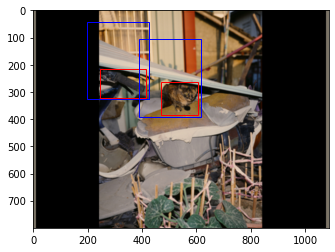

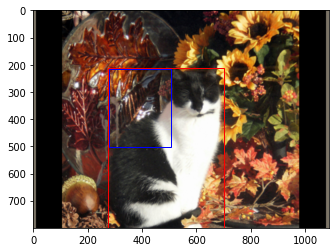

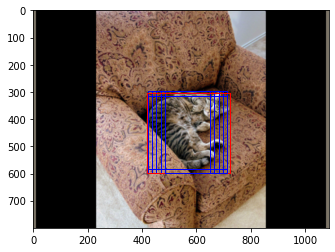

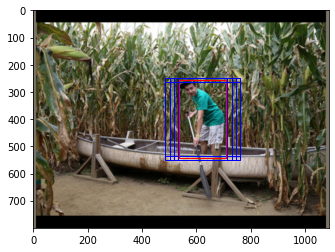

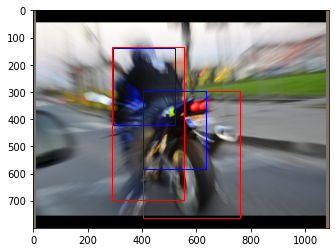

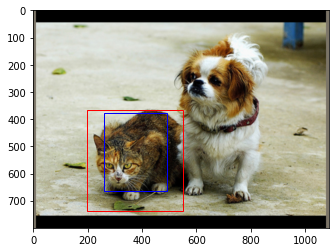

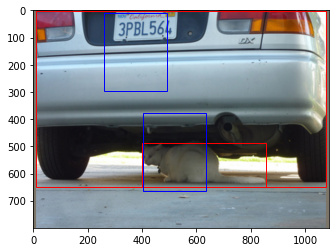

In [94]:
rpn_net = RPNHead(device="cpu")
# push the randomized training data into the dataloader

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

for i,batch in enumerate(train_loader,0):
    # images=batch['images'][0,:,:,:]
    # indexes=batch['index']
    # boxes=batch['bbox']
    images, labels, masks, boxes, indexes = batch
    

    # tx, ty, tw, th
    gt,ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])


    # Flatten the ground truth and the anchors
    # flatten_coord: tx, ty, tw, th
    # flatten_anchors: x, y, w, h
    flatten_coord,flatten_gt,flatten_anchors=output_flattening(ground_coord,gt,rpn_net.get_anchors())
    
    # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
    # decoded_coord: x1, y1, x2, y2
    decoded_coord=output_decoding(flatten_coord,flatten_anchors) #flatten_coord #
   
    # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
    images = transforms.functional.normalize(images,
                                                  [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                  [1/0.229, 1/0.224, 1/0.225], inplace=False)
    fig,ax=plt.subplots(1,1)
    ax.imshow(images[0].permute(1,2,0))
    
    find_cor=(flatten_gt==1).nonzero()
    find_neg=(flatten_gt==-1).nonzero()
          
    for elem in find_cor:
        coord=decoded_coord[elem,:].view(-1)
        anchor=flatten_anchors[elem,:].view(-1)

        col='r'
        rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
        ax.add_patch(rect)
        rect=patches.Rectangle((anchor[0]-anchor[2]/2,anchor[1]-anchor[3]/2),anchor[2],anchor[3],fill=False,color='b')
        # rect=patches.Rectangle((anchor[0],anchor[1]),anchor[2]-anchor[0],anchor[3]-anchor[1],fill=False,color='b')
        ax.add_patch(rect)

    plt.show()

    if(i>5):
        break
        

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

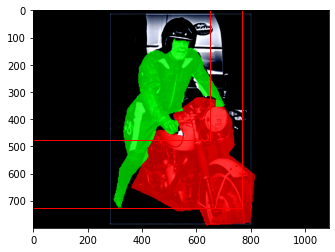

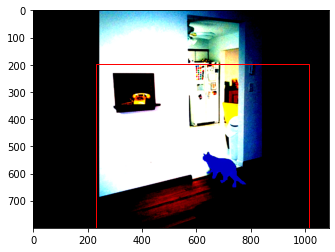

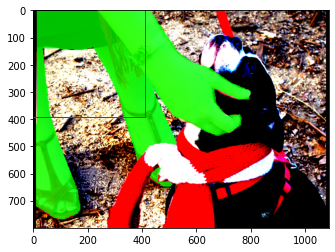

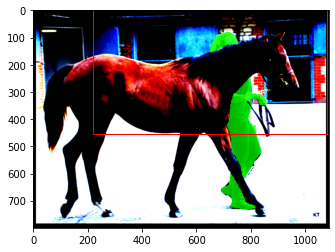

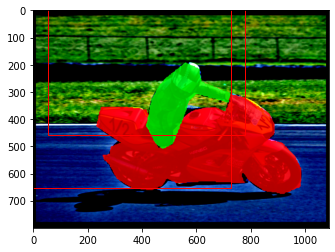

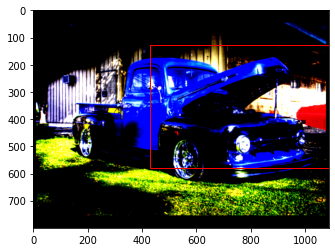

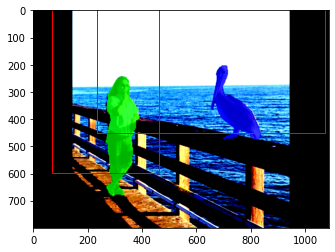

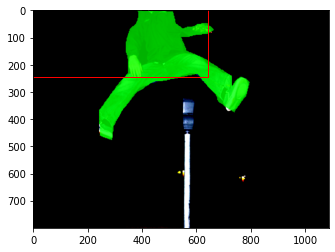

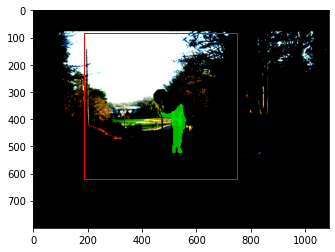

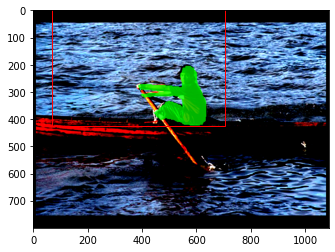

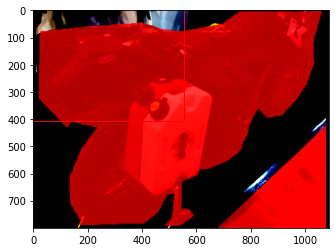

In [93]:
import matplotlib.cm as cm
count=0
rgb_color_list = [np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1])]

for idx,batch in enumerate(train_loader,0):
    i=0

    img, labels, masks, boxes, indexes = batch
    # plot_visual_correctness_batch(images, labels, boxes, masks, indexes, "visual_check", rgb_color_list)


    fig, ax = plt.subplots(1)
    alpha = 0.1
    img_copy = img[0].clone()
    img_copy = img_copy.permute((1, 2, 0)).cpu().numpy()

    for obj_i, obj_mask in enumerate(masks[i], 0):
        obj_label = labels[i][obj_i].to(torch.int32)

        rgb_color = rgb_color_list[obj_label - 1]
        obj_mask_np = np.stack([obj_mask.cpu().numpy(), obj_mask.cpu().numpy(), obj_mask.cpu().numpy()], axis=2)
        img_copy[obj_mask_np != 0] = ((1 - alpha) * rgb_color + alpha * img_copy)[obj_mask_np != 0]

    ax.imshow(img_copy)

    for obj_i, obj_bbox in enumerate(boxes[i], 0):
        obj_w = obj_bbox[2]
        obj_h = obj_bbox[3]
        rect = patches.Rectangle((obj_bbox[0] - obj_bbox[2] / 2, obj_bbox[1] - obj_bbox[3] / 2), obj_w, obj_h, linewidth=1, edgecolor='r',
                                facecolor='none')
        ax.add_patch(rect)

    plt.show()
    count+=1
    if count>10:
      break

## Training

In [17]:
def train_one_epoch(model, train_loader):
    model.train()
    loss_log = 0
    loss_log_c = 0
    loss_log_r = 0
    pbar = tqdm(train_loader)
    # pbar = enumerate(pbar,0)
    for i,batch in enumerate(pbar,0):

        model.zero_grad()
        images, labels, masks, bboxes_list, indexes = batch
        images = images.to(model.device)
        bboxes_list = [b.to(model.device) for b in bboxes_list]
        logits, bbox_regs = model(images)
        gt_clas, gt_coord = model.create_batch_truth(bboxes_list,indexes,images.shape[-2:])
        loss, loss_c, loss_r = model.compute_loss(logits,bbox_regs,gt_clas,gt_coord)
        

        loss.backward()
        optimizer.step()
        loss_log += loss.item()
        loss_log_c += loss_c.item()
        loss_log_r += loss_r.item()
        if (i + 1) % log_every == 0:
            train_losses.append(loss_log / log_every)
            train_losses_c.append(loss_log_c / log_every)
            train_losses_r.append(loss_log_r / log_every)
            pbar.set_postfix({"loss_c": train_losses_c[-1], "loss_r": train_losses_r[-1], "loss": train_losses[-1]})
            
            loss_log = 0
            loss_log_c = 0
            loss_log_r = 0
    return model

In [18]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [19]:
# model = RPNHead()

# model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

In [ ]:
from tqdm import tqdm
model = RPNHead()
model.to(model.device)
batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,  weight_decay=1e-4)

log_every = 10
train_losses = []
train_losses_c = []
train_losses_r = []
val_losses = []
val_losses_c = []
val_losses_r = []
epochs = 2
for _ in range(epochs-1):
    model = train_one_epoch(model, train_loader)

    loss_log = 0
    loss_log_c = 0
    loss_log_r = 0
    for i,batch in enumerate(tqdm(test_loader),0):
        images, labels, masks, bboxes_list, indexes = batch
        images = images.to(model.device)
        bboxes_list = [b.to(model.device) for b in bboxes_list]
        logits, bbox_regs = model(images)
        gt_clas, gt_coord = model.create_batch_truth(bboxes_list,indexes,images.shape[-2:])
        loss, loss_c, loss_r = model.compute_loss(logits,bbox_regs,gt_clas,gt_coord)
        loss_log += loss.item()
        loss_log_c += loss_c.item()
        loss_log_r += loss_r.item()
    val_losses.append(loss_log/(i+1))
    val_losses_c.append(loss_log_c/(i+1))
    val_losses_r.append(loss_log_r/(i+1))


In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [105]:
#Adam
plt.plot(train_losses)
plt.plot(train_losses_c)
plt.plot(train_losses_r)



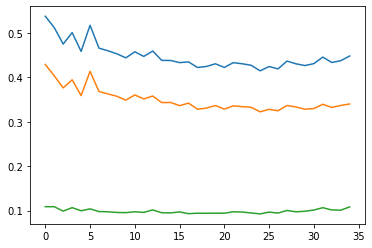

In [ ]:
plt.plot(val_losses)
plt.plot(val_losses_c)
plt.plot(val_losses_r)


In [ ]:
from tqdm import tqdm
model = RPNHead()
model.to(model.device)
batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001,  weight_decay=1e-4)

log_every = 10
train_losses = []
train_losses_c = []
train_losses_r = []
val_losses = []
val_losses_c = []
val_losses_r = []
epochs = 36
for _ in range(epochs-1):
    model = train_one_epoch(model, train_loader)

    loss_log = 0
    loss_log_c = 0
    loss_log_r = 0
    for i,batch in enumerate(tqdm(test_loader),0):
        images, labels, masks, bboxes_list, indexes = batch
        images = images.to(model.device)
        bboxes_list = [b.to(model.device) for b in bboxes_list]
        logits, bbox_regs = model(images)
        gt_clas, gt_coord = model.create_batch_truth(bboxes_list,indexes,images.shape[-2:])
        loss, loss_c, loss_r = model.compute_loss(logits,bbox_regs,gt_clas,gt_coord)
        loss_log += loss.item()
        loss_log_c += loss_c.item()
        loss_log_r += loss_r.item()
    val_losses.append(loss_log/(i+1))
    val_losses_c.append(loss_log_c/(i+1))
    val_losses_r.append(loss_log_r/(i+1))


  0%|          | 0/653 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 164/164 [01:00<00:00,  2.69it/s]


In [ ]:
torch.save(model.state_dict(), 'modelSGD.pth')

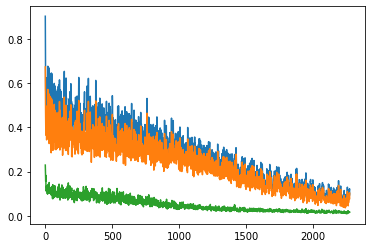

In [ ]:
#SGD
plt.plot(train_losses)
plt.plot(train_losses_c)
plt.plot(train_losses_r)



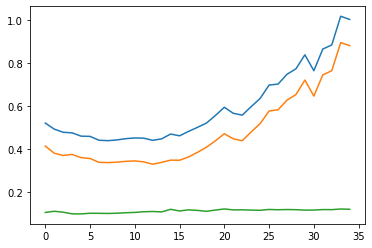

In [ ]:
plt.plot(val_losses)
plt.plot(val_losses_c)
plt.plot(val_losses_r)



##Get pointwise acc, plot top 20 proposals, and before/after nms (saved in drive)

In [24]:
matplotlib.use('Agg')               
# from rpn import RPNHead   #not updated yet

os.makedirs("Top_20_proposals", exist_ok=True)
rpn_net = RPNHead(device="cpu")
rpn_net.load_state_dict(torch.load('model.pth'))
rpn_net.eval()  
total_count=0
total_true=0
os.makedirs("PreNMS", exist_ok=True)
os.makedirs("PostNMS", exist_ok=True)


for i,batch in enumerate(train_loader,0):
    img, labels, masks, bbox_list, index_list = batch
    with torch.no_grad():
        target_clas, _ = rpn_net.create_batch_truth(bbox_list, index_list, img.shape[2:])
        pred_clas, pred_coor = rpn_net(img)

        clas_bin = (pred_clas > 0.5) * 1.0
        gt_mask = target_clas != -1
        result = (clas_bin[gt_mask].float() == target_clas[gt_mask].float())        
        num_TP = torch.sum(result).item()
        total_count+=result.shape[0]
        total_true+=num_TP

        plot_mask_batch(rpn_net, pred_clas, pred_coor, img, bbox_list, index_list, "Top_20_proposals", top_K=20)
        # print(pred_clas[0].shape, pred_coor[0].shape, img[0].shape)out_c,out_r, batch_image, indexes
        nms_clas_list, nms_prebox_list = rpn_net.postprocess(out_c=pred_clas, out_r=pred_coor, batch_image=img, indexes=index_list, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=5)
    if i>30:
      break
print("pointwise acc: ",total_true/total_count)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


pointwise acc:  0.8441901408450704
